In [41]:
import numpy as np
import cvxpy as cp
import itertools as it
import scipy.linalg as spla
import matplotlib.pyplot as plt
import pennylane as qml

In [2]:
def pauli_basis(n):
    I = np.eye(2).astype(complex)
    X = np.array([[0, 1], [1, 0]], complex)
    Y = np.array([[0, -1j], [1j, 0]], complex)
    Z = np.array([[1, 0], [0, -1]], complex)
    basis = {
        "labels": [],
    }
    b = []
    for comb in list(it.product([0, 1, 2, 3], repeat=n))[1:]:
        p = 1.
        basis["labels"].append(comb)
        for c in comb:
            if c == 0:
                p = np.kron(p, I)
            elif c == 1:
                p = np.kron(p, X)
            elif c == 2:
                p = np.kron(p, Y)
            elif c == 3:
                p = np.kron(p, Z)
        b.append(p)
    basis["basis"] = np.stack(b)
    return basis

def two_body_projection_indices(basis):
    basis_indices = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            basis_indices.append(1)
        else:
            basis_indices.append(0)
    return basis_indices

def two_body_projection(theta, basis):
    indices = two_body_projection_indices(basis)
    return np.array([t * indices[i] for i,t in enumerate(theta)])
    
def two_body_restriction_basis(basis):
    new_basis = {
        "labels": [],
    }
    basis_elements = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            new_basis["labels"].append(b)
            basis_elements.append(np.array(basis["basis"][i]))
    new_basis["basis"] = np.stack(basis_elements)
    return new_basis

def specific_basis_terms(basis, specific_labels, ts):
    theta = []
    for l in basis["labels"]:
        if l in specific_labels:
            theta.append(ts[specific_labels.index(l)])
        else:
            theta.append(0)
    return np.array(theta)
    
def hamiltonian_from_parameters(parameters, basis):
    return np.einsum("ijk,i->jk", basis, parameters)

def unitary_from_parameters(parameters, basis):
    h = hamiltonian_from_parameters(parameters, basis)
    return spla.expm(1.j*h)

def parameters_from_hamiltonian(hamiltonian, basis):
    return np.real(np.einsum("ijk, kj->i", basis, hamiltonian)) / (len(hamiltonian[0]))

def unitary_fidelity(U1, U2):
    return np.abs(np.trace(U1.conj().T @ U2))/len(U1[0])

def phi_fidelity(phi, phi_basis, U2):
    phi_H = hamiltonian_from_parameters(phi, phi_basis)
    phi_U = spla.expm(1.j * phi_H)
    return unitary_fidelity(phi_U, U2)

def geodesic_ham(U, V):
    gamma = -1.j * spla.logm(V @ U.conj().T)
    return gamma

def plot_parameters(labels, parameters, title=False, figsize=[14,6]):
    labels = ["".join(map(str, l)) for l in labels]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels,parameters)
    ax.grid()
    if title:
        plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_fidelities(steps, fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    ax.plot(steps, fidelities)
    if title:
        plt.title(title)
    plt.show()
    
def plot_multi_fidelities(multi_steps, multi_fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, fidelities in enumerate(multi_fidelities):
        fid = [1 - f for f in fidelities] 
        ax.plot(multi_steps[i], fid)
    if title:
        plt.title(title)
    ax.set_yscale('log')
    ax.set_xlabel("Step")
    ax.set_ylabel("1 - fidelity")
    plt.show()
    
def plot_direction_indices(indices, title=False):
    plt.hist(indices, bins=len(indices))
    if title:
        plt.title(title)
    plt.show()

Geodesic update step function

In [3]:
def geodesic_update_step(target_V, phi, phi_basis, step_size=0.1):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
    gamma = geodesic_ham(phi_U, target_V)
    
    # Step 2: update along the direction of the geodesic by the step size
    X = spla.expm(1.j * step_size * gamma)
    theta_U = X @ phi_U
    
    # Step 3: project the theta onto the new phi
    theta_H = -1.j * spla.logm(theta_U)
    new_phi = two_body_projection(parameters_from_hamiltonian(theta_H, phi_basis["basis"]), phi_basis)
    
    return new_phi

Geodesic direction update step function

In [107]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)

theta0 = parameters_from_hamiltonian(-1.j*spla.logm(Vtoff), basis_full["basis"])
phi0 = two_body_projection(theta0, basis_full)
U0 = unitary_from_parameters(phi0, basis_full["basis"])

su = qml.SpecialUnitary(phi0, [i for i in range(nqubits)])
omegas = su.get_one_parameter_generators(interface="jax")
# unitary_fidelity(su.matrix(), Vtoff)
# print(omegas)

inner_products = []
projected_indices = two_body_projection_indices(basis_full)
for i, omega in enumerate(omegas):
    if projected_indices[i]:
        inner_products.append(unitary_fidelity(omega, geodesic_ham(U0, Vtoff)))
    else:
        inner_products.append(0)
    delta_phi = np.zeros(len(phi0))
    delta_phi[i] = step_size
    new_phi = phi0 - delta_phi
    print(f"{i} : {unitary_fidelity(U0, Vtoff)-unitary_fidelity(unitary_from_parameters(new_phi, basis_full['basis']), Vtoff)}")

index_max = np.argmax(np.array(inner_products))

step_size = 0.001
delta_phi = np.zeros(len(phi0))
delta_phi[index_max] = step_size
print(delta_phi)
new_phi = phi0 + delta_phi
print(new_phi)
print(unitary_fidelity(U0, Vtoff))
print(unitary_fidelity(unitary_from_parameters(new_phi, basis_full["basis"]), Vtoff))

print(omega[index_max])
print(inner_products)

0 : 4.61939727691707e-07
1 : 4.0803936895983384e-07
2 : 4.0803936895983384e-07
3 : 4.0803936895983384e-07
4 : 4.0803936895983384e-07
5 : 3.932590767474764e-07
6 : 3.932590767474764e-07
7 : 4.0803936895983384e-07
8 : 4.0803936895983384e-07
9 : 3.932590767474764e-07
10 : 3.932590767474764e-07
11 : 4.61939727691707e-07
12 : 4.61939727691707e-07
13 : 4.0803936895983384e-07
14 : 4.0803936895983384e-07
15 : 4.0803936895983384e-07
16 : 4.0803936895983384e-07
17 : 3.932590767474764e-07
18 : 3.932590767474764e-07
19 : 3.932590767474764e-07
20 : 3.932590767474764e-07
21 : 4.0803936895983384e-07
22 : 4.0803936895983384e-07
23 : 3.932590767474764e-07
24 : 3.932590767474764e-07
25 : 4.0803936895983384e-07
26 : 4.0803936895983384e-07
27 : 4.0803936895983384e-07
28 : 4.0803936895983384e-07
29 : 3.932590767474764e-07
30 : 3.932590767474764e-07
31 : 4.0803936895983384e-07
32 : 4.0803936895983384e-07
33 : 3.932590767474764e-07
34 : 3.932590767474764e-07
35 : 3.932590767474764e-07
36 : 3.932590767474764e

In [112]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)

specific_labels = [(3,0,0), (0,3,0), (3,0,1), (0,3,1), (3,3,0), (0,0,1), (0,3,3), (3,0,3)]
ts = [-np.pi/8, -np.pi/8, np.pi/8, np.pi/8, -3*np.pi/8, -2*np.pi/8, np.sqrt(15)*np.pi/8, -np.sqrt(15)*np.pi/8]
theta_solution = specific_basis_terms(basis_full, specific_labels, ts)

theta0 = np.array(theta_solution) + np.random.rand(len(basis_full["basis"]))/1000
phi0 = two_body_projection(theta0, basis_full)
U0 = unitary_from_parameters(phi0, basis_full["basis"])

su = qml.SpecialUnitary(phi0, [i for i in range(nqubits)])
omegas = su.get_one_parameter_generators(interface="jax")
# unitary_fidelity(su.matrix(), Vtoff)
# print(omegas)

inner_products = []
projected_indices = two_body_projection_indices(basis_full)
for i, omega in enumerate(omegas):
    if projected_indices[i]:
        inner_products.append(unitary_fidelity(omega, geodesic_ham(U0, Vtoff)))
    else:
        inner_products.append(0)
    delta_phi = np.zeros(len(phi0))
    delta_phi[i] = step_size
    new_phi = phi0 - delta_phi
    print(f"{i} : {unitary_fidelity(U0, Vtoff)-unitary_fidelity(unitary_from_parameters(new_phi, basis_full['basis']), Vtoff)}")

index_max = np.argmax(np.array(inner_products))
print(index_max)

step_size = 0.001
delta_phi = np.zeros(len(phi0))
delta_phi[index_max] = step_size
print(delta_phi)
new_phi = phi0 - delta_phi
print(new_phi)
print(unitary_fidelity(U0, Vtoff))
print(unitary_fidelity(unitary_from_parameters(new_phi, basis_full["basis"]), Vtoff))

print(omega[index_max])
print(inner_products)

0 : -7.187539674546883e-09
1 : -5.80121634063957e-08
2 : -8.46071266380477e-08
3 : -3.762303657506294e-08
4 : -5.876596276266355e-08
5 : -3.324043196251125e-08
6 : -2.727067949237494e-08
7 : -7.575906679768707e-09
8 : 3.163081896406794e-08
9 : -4.1990249055601225e-08
10 : -2.030028345423318e-08
11 : -7.153893921696408e-09
12 : -4.655304175482655e-08
13 : -7.241899901977433e-08
14 : -7.413077185436379e-08
15 : -3.523501002078433e-08
16 : -3.242634261102495e-08
17 : -3.989786290237163e-08
18 : 6.821960218950096e-09
19 : -9.160250780126944e-09
20 : 9.62423030159698e-10
21 : 5.89092719049944e-09
22 : 1.7821051301325497e-09
23 : -8.972144027730167e-09
24 : -1.83084103433373e-10
25 : -8.783627714059605e-09
26 : 1.75967540538835e-09
27 : -1.83484502036535e-08
28 : 3.7217188220139974e-09
29 : -1.1881563177773558e-08
30 : 4.963231048371597e-08
31 : -1.5146183085512632e-08
32 : -5.2716508269767814e-08
33 : 1.1325476334533846e-08
34 : -3.21595278185427e-08
35 : -8.066556977937012e-09
36 : -1.3399

In [117]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)

theta0 = np.random.rand(len(basis_full["basis"]))
phi0 = two_body_projection(theta0, basis_full)
U0 = unitary_from_parameters(phi0, basis_full["basis"])

su = qml.SpecialUnitary(phi0, [i for i in range(nqubits)])
omegas = su.get_one_parameter_generators(interface="jax")
# unitary_fidelity(su.matrix(), Vtoff)
# print(omegas)

inner_products = []
projected_indices = two_body_projection_indices(basis_full)
for i, omega in enumerate(omegas):
    if projected_indices[i]:
        inner_products.append(unitary_fidelity(omega, geodesic_ham(U0, Vtoff)))
    else:
        inner_products.append(0)
    delta_phi = np.zeros(len(phi0))
    delta_phi[i] = step_size
    new_phi = phi0 - delta_phi
    print(f"{i} : {unitary_fidelity(U0, Vtoff)-unitary_fidelity(unitary_from_parameters(new_phi, basis_full['basis']), Vtoff)}")

index_max = np.argmax(np.array(inner_products))
print(index_max)

step_size = 0.05
delta_phi = np.zeros(len(phi0))
delta_phi[index_max] = step_size
print(delta_phi)
new_phi = phi0 - delta_phi
print(new_phi)
print(unitary_fidelity(U0, Vtoff))
print(unitary_fidelity(unitary_from_parameters(new_phi, basis_full["basis"]), Vtoff))

print(omega[index_max])
print(inner_products)

0 : -0.0011677956011890422
1 : -0.0016694120266974866
2 : -0.001891748067379323
3 : 0.0017994781301398644
4 : 0.0008038990252953737
5 : -0.0002155149052588956
6 : -0.0006895994472519984
7 : 0.0012005357996377197
8 : 0.00022949666485991282
9 : 0.0019489009351287834
10 : 0.0007493027967123422
11 : -0.00010812542660235125
12 : 0.0004242248409727367
13 : 0.0013213799046994656
14 : 0.0002930256873992787
15 : -0.0010541404825056555
16 : -0.001066586417386911
17 : -0.001298901937017538
18 : 0.0003610061640230422
19 : -0.0007720108612367105
20 : 0.0005105551818337106
21 : 0.0002784298691920206
22 : -0.0008027578800901825
23 : -0.0008921722843705515
24 : -0.0007241756323081161
25 : -0.000633529255941151
26 : -0.0004069767054039053
27 : 0.0006658332542716083
28 : -0.00012156960351095147
29 : -0.000661672976187716
30 : 0.00037406488482430444
31 : -0.0009823379996940773
32 : 0.00032308949807410836
33 : -0.0012007359383933436
34 : 6.633265773769992e-05
35 : -0.0004747494574851019
36 : -0.0005489647

In [233]:
def step_size_map(fid):
    return (1-fid)/2 + 0.005

In [226]:
def step_size_map(fid):
    return (1-fid)/5 + 0.0008

In [254]:
def step_size_map(fid):
    return (1-fid**2)/2 + 0.001

In [240]:
def construct_new_phi(phi, phi_basis, index, target_V, step_size):
    delta_phi = np.zeros(len(phi))
    delta_phi[index] = step_size
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
    else:
        new_phi = new_phi_plus
    return new_phi

def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
    delta_phi = step_size * delta_phi
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
    else:
        new_phi = new_phi_plus
    return new_phi

def geodesic_direction_update_step(target_V, phi, phi_basis, step_size=0.01, precision=0.9999):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
    gamma = geodesic_ham(phi_U, target_V)
    
    # Step 2: find the Omegas
    su = qml.SpecialUnitary(phi, [i for i in range(nqubits)])
    omegas = su.get_one_parameter_generators(interface="jax")
    
    print(unitary_fidelity(omegas[0], omegas[1]))
    
    # Step 3: find the Omega index that is closest to the geodesic gamma with the two-body restriction
    inner_products = []
    projected_indices = two_body_projection_indices(phi_basis)
    for i, omega in enumerate(omegas):
        if projected_indices[i]:
            inner_products.append(unitary_fidelity(omega, gamma))
        else:
            inner_products.append(0)
    inner_products = np.array(inner_products)
    args_sorted = np.flip(np.argsort(inner_products))

    # Step 4: Apply a small push in the right direction to give a new phi
    omega_ind = 0
    for i, index in enumerate(args_sorted):
        if inner_products[index]:
            omega_ind += 1
            new_phi = construct_new_phi(phi, phi_basis, index, target_V, step_size)
            fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
            fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)
            if phi_fidelity(new_phi, phi_basis["basis"], target_V) > precision:
                print("Solution found!")
                break
            elif (not np.isclose(fidelity_phi, fidelity_new_phi)) and (fidelity_new_phi > fidelity_phi):
                print(f"omega_ind: {omega_ind} --- fidelity new = {fidelity_new_phi}, fidelity old = {fidelity_phi}")
                print(f"inner_products = {inner_products}")
                print(f"args_sorted = {args_sorted}")
                break
            elif i == len(args_sorted)-1:
                print(f"[Fidelity = {fidelity_phi}] No good Omega direction; giving it a push in random direction.")
                new_phi = two_body_projection(np.array(new_phi) + (10 * step_size * np.random.rand(len(phi_basis["basis"]))), phi_basis)
        else:
            if i == len(args_sorted)-1:
                print(f"[Fidelity = {fidelity_phi}] No good Omega direction; giving it a push in random direction.")
                new_phi = two_body_projection(np.array(new_phi) + (10 * step_size * np.random.rand(len(phi_basis["basis"]))), phi_basis)
    return new_phi, omega_ind

In [241]:
def linear_combination_coeffs(combination_vectors, target_vector):
    x = cp.Variable(combination_vectors.shape[0])
    cost = cp.sum_squares(combination_vectors.T @ x - target_vector)
#     prob = cp.Problem(cp.Minimize(cost), [x >= 0, np.dot(x,x) == 1])
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    return x.value

In [257]:
def geodesic_direction_update_step(target_V, phi, phi_basis, step_size=0.01, precision=0.9999, step_count=(None,None)):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
    gamma = geodesic_ham(phi_U, target_V)
    gamma_phi = parameters_from_hamiltonian(gamma, phi_basis["basis"])
    
    # Step 2: find the Omegas
    su = qml.SpecialUnitary(phi, [i for i in range(nqubits)])
    omegas = su.get_one_parameter_generators(interface="jax")
    omega_phis = np.array([parameters_from_hamiltonian(omega, phi_basis["basis"]) for omega in omegas])
#     print(unitary_fidelity(omegas[0], omegas[1]))
#     print(omega_phis)
#     print(omega_phis.shape)
#     print(omega_phis.shape[0])
    
#     print(gamma_phi)
#     print(gamma_phi.shape)

    # Step 3: find the Omega index that is closest to the geodesic gamma with the two-body restriction
    inner_products = []
    projected_indices = two_body_projection_indices(phi_basis)
    for i, omega in enumerate(omegas):
        if projected_indices[i]:
            inner_products.append(unitary_fidelity(omega, gamma))
        else:
            inner_products.append(0)
    inner_products = np.array(inner_products)
    args_sorted = np.flip(np.argsort(inner_products))

    # Step 4: Find a linear combination of Omegas that gives the geodesic and update parameters
    coeffs = linear_combination_coeffs(omega_phis, gamma_phi)
    if coeffs is None:
        print(f"[{step_count[0]}/{step_count[1]}] Didn't find coefficients for Omega direction; giving it a push in random direction.", end='\r')
        new_phi = two_body_projection(np.array(phi) + (step_size * np.random.rand(len(phi_basis["basis"])) - 1/2), phi_basis)
        omega_ind = 1
    else:
        proj_coeffs = np.multiply(projected_indices, coeffs)
        proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))


        # Step 5: Apply a small push in the right direction to give a new phi
        new_phi = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size)
        fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
        fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)

        omega_ind = 0
        if phi_fidelity(new_phi, phi_basis["basis"], target_V) > precision:
            print(f"\n[{step_count[0]}/{step_count[1]}] Solution found!")
        elif (not np.isclose(fidelity_phi, fidelity_new_phi)) and (fidelity_new_phi > fidelity_phi):
            pass
    #         print(f"fidelity new = {fidelity_new_phi}, fidelity old = {fidelity_phi}")
        else:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] The Omega geodesic gave a negative fidelity update for this step.", end='\r')
#             new_phi = two_body_projection(np.array(new_phi) + (step_size * (np.random.rand(len(phi_basis["basis"])) - 1/2)/len(phi_basis["basis"])), phi_basis)
            omega_ind = 1

    # What about with the terms that do not appear in the two-body projection removed?
#     print(f"unprojected coeffs = {coeffs}")

    # Check the overlap of the combination of omegas with the geodesic
#     print(f"projected indices = {projected_indices}")
#     print(f"projected coeffs = {proj_normed_coeffs}")
#     print(f"coeffs norm = {np.dot(proj_normed_coeffs, proj_normed_coeffs)}")
#     print(f"coeffs inner product = {unitary_fidelity(hamiltonian_from_parameters(coeffs, phi_basis['basis']), hamiltonian_from_parameters(coeffs, phi_basis['basis']))}")
#     print(f"geodesic inner product = {unitary_fidelity(gamma, gamma)}")
#     print(f"coeffs geodesic inner product = {unitary_fidelity(hamiltonian_from_parameters(coeffs, phi_basis['basis']), gamma)}")
#     print(f"inner products = {inner_products}" )
    
    # Check the new phi constructed from the coeffs found
#     new_phi = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size)
#     fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
#     fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)
#     print(f"fidelity_phi = {fidelity_phi}")   
#     print(f"fidelity_new_phi = {fidelity_new_phi}")
    
    return new_phi, omega_ind

In [250]:
def rand_init_fidelities(target_V, basis, num_steps, step_size, update_func=geodesic_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    phis = [two_body_projection(np.random.rand(len(basis["basis"])), basis)]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
            break
    return steps[:len(fidelities)], fidelities, phis, indices

def anchor_rand_init_fidelities(init, target_V, basis, num_steps, step_size, update_func=geodesic_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    init_phi = two_body_projection(np.array(init) + np.random.rand(len(basis["basis"]))/5, basis)
    phis = [init_phi]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
            break
    return steps[:len(fidelities)], fidelities, phis, indices

def anchor_init_fidelities(init, target_V, basis, num_steps, step_size, update_func=geodesic_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    init_phi = two_body_projection(np.array(init), basis)
    phis = [init_phi]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
            break
    return steps[:len(fidelities)], fidelities, phis, indices

Toffoli gate

In [262]:
nqubits = 3
Vtoff = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1],
                  [0,0,0,0,0,0,1,0]])

w = np.exp(1.j * 2 * np.pi / 8)
Vqft = np.array([[1,1,1,1,1,1,1,1],
                 [1, w, w**2, w**3, w**4, w**5, w**6, w**7],
                 [1, w**2, w**4, w**6, w**8, w**10, w**12, w**14],
                 [1, w**3, w**6, w**9, w**12, w**15, w**18, w**21],
                 [1, w**4, w**8, w**12, w**16, w**20, w**24, w**28],
                 [1, w**5, w**10, w**15, w**20, w**25, w**30, w**35],
                 [1, w**6, w**12, w**18, w**24, w**30, w**36, w**42],
                 [1, w**7, w**14, w**21, w**28, w**35, w**42, w**49]])

w4 = np.exp(1.j * 2 * np.pi / 16)
Vqft4 = np.array([[w4**(i*j) for i in range(16)] for j in range(16)])

w5 = np.exp(1.j * 2 * np.pi / 32)
Vqft5 = np.array([[w5**(i*j) for i in range(32)] for j in range(32)])

Random initialisation and then plot of fidelities against step


[3/1000] [Fidelity = 0.18879473730236485] The Omega geodesic gave a negative fidelity update for this step.
[8/1000] [Fidelity = 0.3314096547648226] The Omega geodesic gave a negative fidelity update for this step.
[9/1000] [Fidelity = 0.31913081714488156] The Omega geodesic gave a negative fidelity update for this step.
[10/1000] [Fidelity = 0.302221688394943] The Omega geodesic gave a negative fidelity update for this step.
[16/1000] [Fidelity = 0.39617157302010186] The Omega geodesic gave a negative fidelity update for this step.
[17/1000] [Fidelity = 0.3899983556920043] The Omega geodesic gave a negative fidelity update for this step.
[20/1000] [Fidelity = 0.45148417087940773] The Omega geodesic gave a negative fidelity update for this step.
[24/1000] [Fidelity = 0.4770984501813345] The Omega geodesic gave a negative fidelity update for this step.
[26/1000] [Fidelity = 0.49336884398823] The Omega geodesic gave a negative fidelity update for this step.
[27/1000] [Fidelity = 0.48712

[66/1000] [Fidelity = 0.7066118882234212] The Omega geodesic gave a negative fidelity update for this step.
[67/1000] [Fidelity = 0.6998449814606352] The Omega geodesic gave a negative fidelity update for this step.
[68/1000] [Fidelity = 0.6984987331996599] The Omega geodesic gave a negative fidelity update for this step.
[69/1000] [Fidelity = 0.6963016896260675] The Omega geodesic gave a negative fidelity update for this step.
[70/1000] [Fidelity = 0.6886023057966489] The Omega geodesic gave a negative fidelity update for this step.
[71/1000] [Fidelity = 0.6836644816404598] The Omega geodesic gave a negative fidelity update for this step.
[73/1000] [Fidelity = 0.675500271614878] The Omega geodesic gave a negative fidelity update for this step.
[74/1000] [Fidelity = 0.6604767377509252] The Omega geodesic gave a negative fidelity update for this step.
[76/1000] [Fidelity = 0.6721216685709587] The Omega geodesic gave a negative fidelity update for this step.
[77/1000] [Fidelity = 0.66247

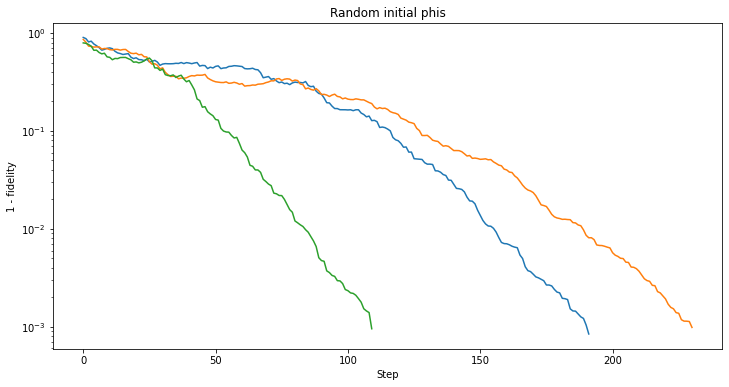

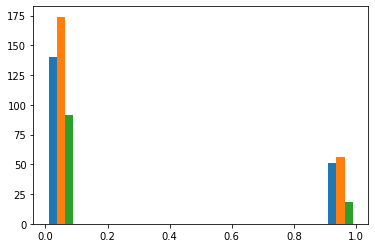

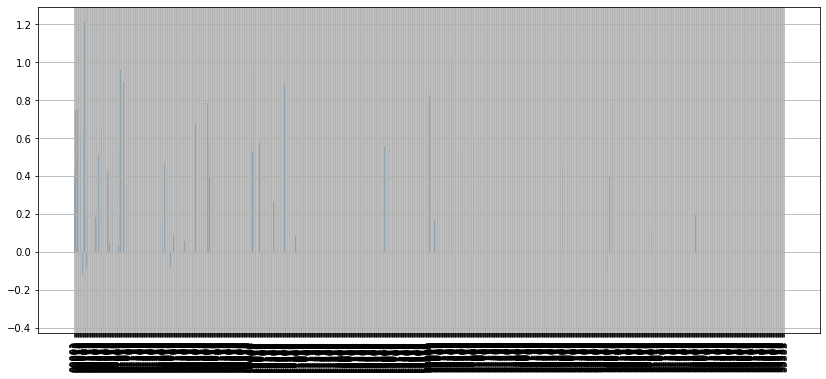

In [263]:
nqubits=5
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
#     steps, fidelities, phis = rand_init_fidelities(Vtoff, basis_full, num_steps=5, step_size=0.1, update_func=geodesic_update_step)
    steps, fidelities, phis, indices = rand_init_fidelities(Vqft5, basis_full, num_steps=1000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
#     print(f"phi = {phis[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
# for i, indices in enumerate(multi_indices):
#     plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])


[4/10000] [Fidelity = 0.37936051141201] The Omega geodesic gave a negative fidelity update for this step.
[8/10000] [Fidelity = 0.4356141444114084] The Omega geodesic gave a negative fidelity update for this step.
[10/10000] [Fidelity = 0.458151379441768] The Omega geodesic gave a negative fidelity update for this step.
[19/10000] [Fidelity = 0.6133956610478082] The Omega geodesic gave a negative fidelity update for this step.
[23/10000] [Fidelity = 0.6874029990523016] The Omega geodesic gave a negative fidelity update for this step.
[25/10000] [Fidelity = 0.7341952719510174] The Omega geodesic gave a negative fidelity update for this step.
[27/10000] [Fidelity = 0.7311597162971782] The Omega geodesic gave a negative fidelity update for this step.
[95/10000] Solution found!
Final fidelity = 0.9990622050848247

[4/10000] [Fidelity = 0.1865647097814203] The Omega geodesic gave a negative fidelity update for this step.
[15/10000] [Fidelity = 0.6775581664264957] The Omega geodesic gave a 

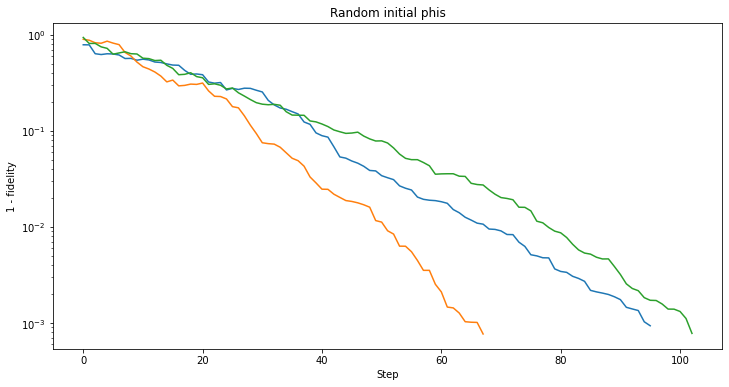

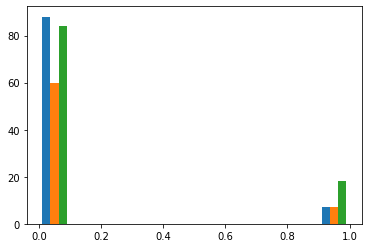

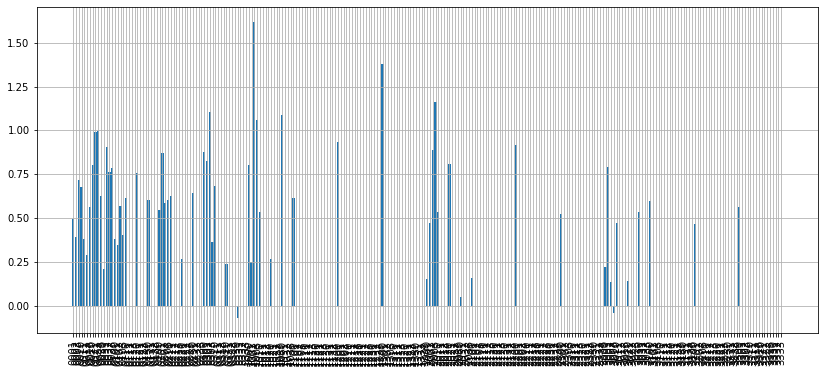

In [261]:
nqubits=4
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
#     steps, fidelities, phis = rand_init_fidelities(Vtoff, basis_full, num_steps=5, step_size=0.1, update_func=geodesic_update_step)
    steps, fidelities, phis, indices = rand_init_fidelities(Vqft4, basis_full, num_steps=10000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
#     print(f"phi = {phis[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
# for i, indices in enumerate(multi_indices):
#     plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

[5845/10000] Solution found!989997880909486] The Omega geodesic gave a negative fidelity update for this step.
Final fidelity = 0.9990005436958694
[3805/10000] Solution found!989992287860471] The Omega geodesic gave a negative fidelity update for this step.
Final fidelity = 0.9990004522853302
[4802/10000] Solution found!989983404719562] The Omega geodesic gave a negative fidelity update for this step.
Final fidelity = 0.9990017438049759


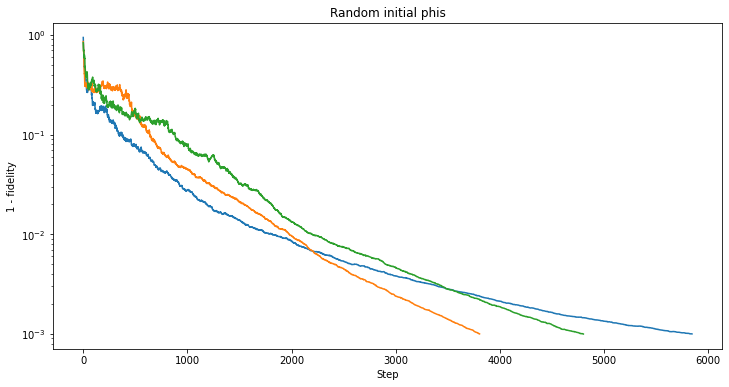

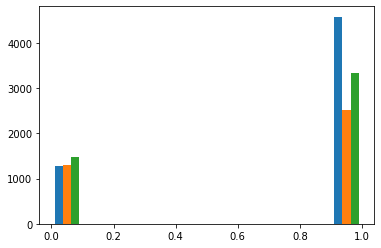

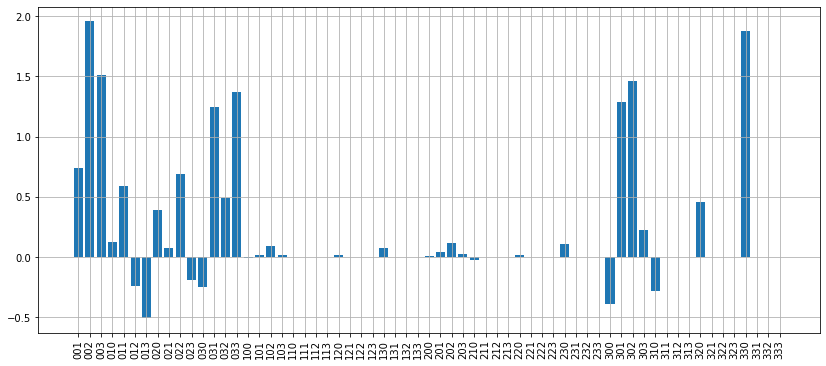

In [255]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
#     steps, fidelities, phis = rand_init_fidelities(Vtoff, basis_full, num_steps=5, step_size=0.1, update_func=geodesic_update_step)
    steps, fidelities, phis, indices = rand_init_fidelities(Vtoff, basis_full, num_steps=10000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
#     print(f"phi = {phis[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
# for i, indices in enumerate(multi_indices):
#     plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

Final fidelity = 0.9978766495441184122093] The Omega geodesic gave a negative fidelity update for this step..
Final fidelity = 0.99785622284606217587419] The Omega geodesic gave a negative fidelity update for this step.
Final fidelity = 0.99789780530965122974702] The Omega geodesic gave a negative fidelity update for this step.


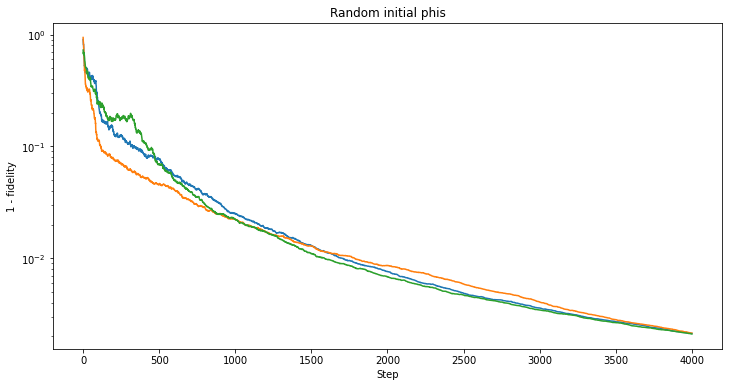

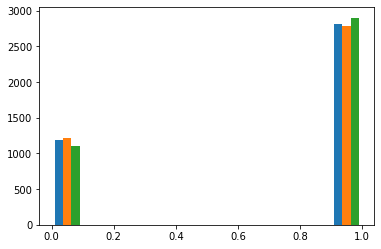

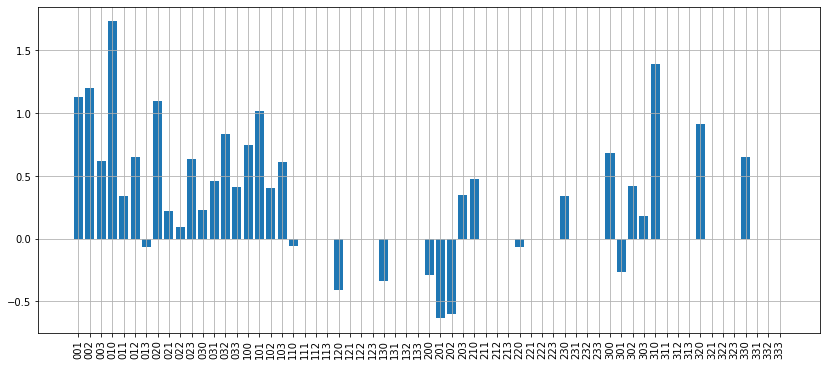

In [252]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
#     steps, fidelities, phis = rand_init_fidelities(Vtoff, basis_full, num_steps=5, step_size=0.1, update_func=geodesic_update_step)
    steps, fidelities, phis, indices = rand_init_fidelities(Vtoff, basis_full, num_steps=10000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
#     print(f"phi = {phis[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
# for i, indices in enumerate(multi_indices):
#     plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

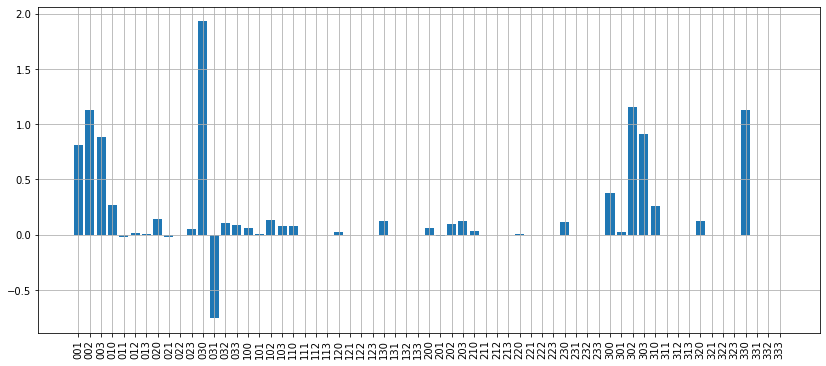

In [324]:
plot_parameters(basis_full["labels"], phis[-1])

Random initialisations around known solution with Hamiltonian 
$H_\textrm{toff} = \frac{9\pi}{8} + \frac{3\pi}{4}X_3 - \frac{\pi}{8}(Z_1 + Z_2) + \frac{\pi}{8}Z_1 Z_2 + \frac{\pi}{8}(Z_1 X_3 + Z_2 X_3) - \frac{\sqrt{7}\pi}{8}(Z_1 Z_3 - Z_2 Z_3)$, or
$H_\textrm{toff} = \frac{\pi}{8} \left[ -Z_1 - Z_2 + Z_1 X_3 + Z_2 X_3 + 5 - 3 Z_1 Z_2 - 2 X_3 + \sqrt{15} Z_2 Z_3 - \sqrt{15} Z_1 Z_3\right]$

[-0.78539816  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.39269908
  0.39269908  0.          1.520917    0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.39269908
  0.39269908  0.         -1.520917    0.          0.          0.
  0.          0.          0.          0.          0.         -1.17809725
  0.          0.          0.        ]


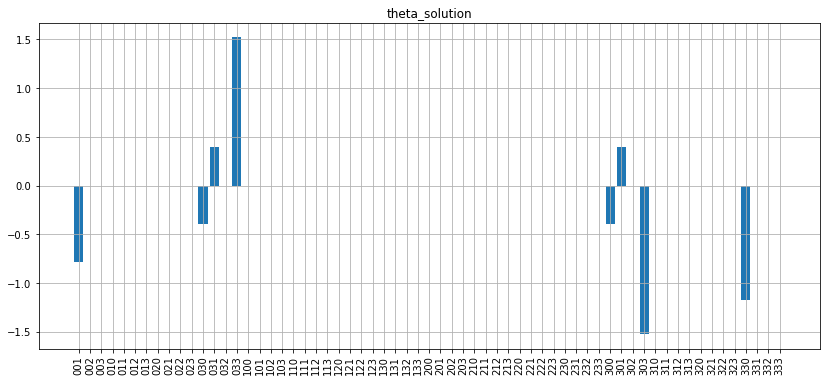

known solution fidelity = 0.9999999999999999
[Fidelity = 0.9986618600731103] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9985776000453584] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9985031354349756] No good Omega direction; giving it a push in random direction
Final fidelity = 0.998182489502877
Final fidelity = 0.9990011565932387
Final fidelity = 0.9990114273245737


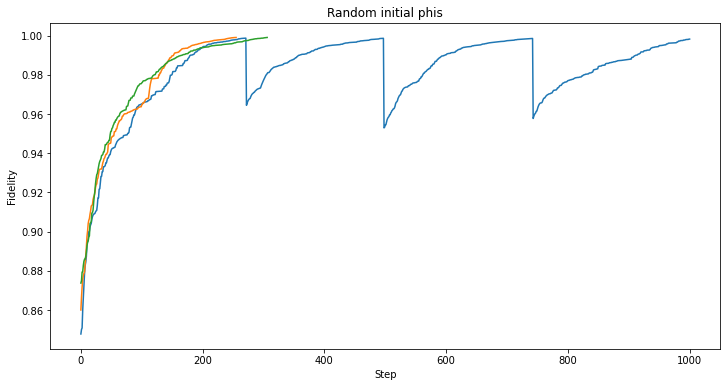

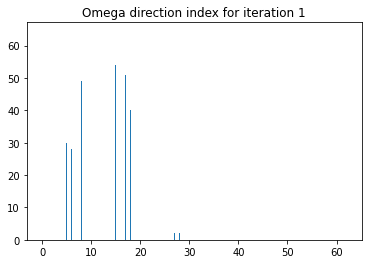

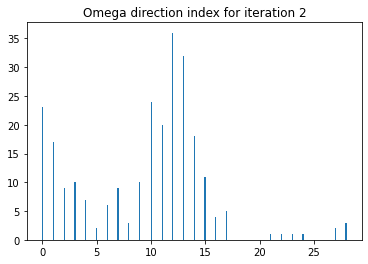

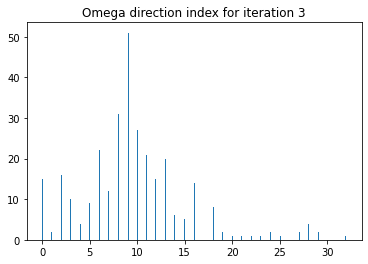

In [373]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

# Create theta for known solution
# specific_labels = [(0,0,1), (3,0,0), (0,3,0), (3,3,0), (3,0,1), (0,3,1), (3,0,3), (0,3,3)]
# ts = [6*np.pi/8, -np.pi/8, -np.pi/8, np.pi/8, np.pi/8, np.pi/8, -np.sqrt(7)*np.pi/8, -np.sqrt(7)*np.pi/8]
# print(len(specific_labels))
# print(len(ts))
# print((3,3,0) in specific_labels)
# print(basis_full["labels"])
specific_labels = [(3,0,0), (0,3,0), (3,0,1), (0,3,1), (3,3,0), (0,0,1), (0,3,3), (3,0,3)]
ts = [-np.pi/8, -np.pi/8, np.pi/8, np.pi/8, -3*np.pi/8, -2*np.pi/8, np.sqrt(15)*np.pi/8, -np.sqrt(15)*np.pi/8]

theta_solution = specific_basis_terms(basis_full, specific_labels, ts)
# print(theta_solution)
# print(len(theta_solution))
# print(hamiltonian_from_parameters(theta_solution, basis_full["basis"]))
plot_parameters(basis_full["labels"], theta_solution, "theta_solution")

print(f"known solution fidelity = {phi_fidelity(theta_solution, basis_full['basis'], Vtoff)}")

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices = anchor_rand_init_fidelities(theta_solution, Vtoff, basis_full, num_steps=1000, step_size=0.01, update_func=geodesic_direction_update_step, precision=0.999)
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
for i, indices in enumerate(multi_indices):
    plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")

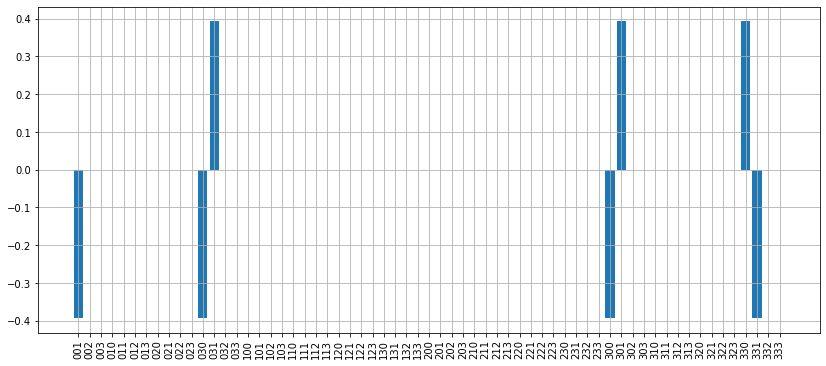

known solution fidelity = 1.0
Final fidelity = 0.92074232526274483694734] The Omega geodesic alignment didn't work; giving it a push in random direction.


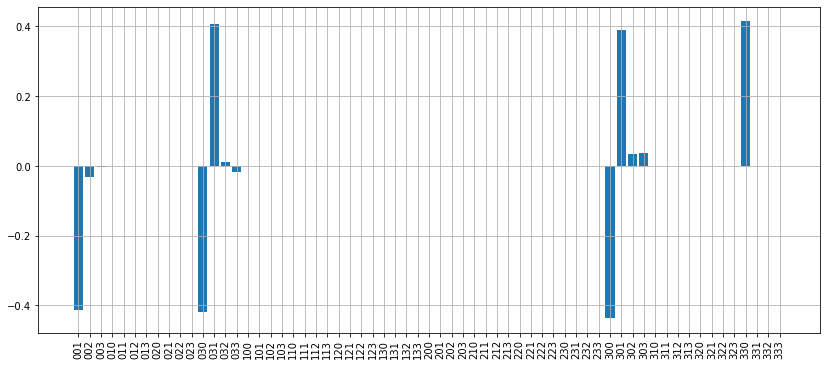

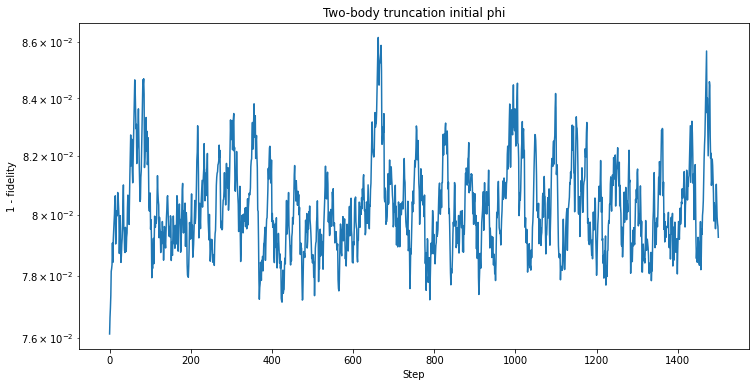

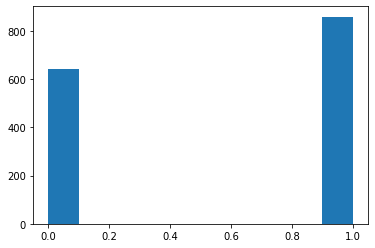

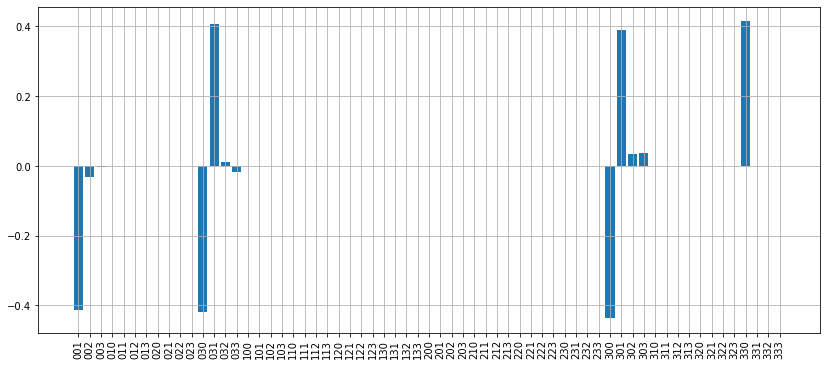

In [230]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 1

theta_solution = parameters_from_hamiltonian(-1.j*spla.logm(Vtoff), basis_full["basis"])
plot_parameters(basis_full["labels"], theta_solution)
print(f"known solution fidelity = {phi_fidelity(theta_solution, basis_full['basis'], Vtoff)}")

# np.diag(len(theta_solution))
multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices = anchor_init_fidelities(theta_solution, Vtoff, basis_full, num_steps=1500, step_size=0.01, update_func=geodesic_direction_update_step, precision=0.99999)
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)
    
plot_parameters(basis_full["labels"], phis[-1])
plot_multi_fidelities(multi_steps, multi_fidelities, title="Two-body truncation initial phi")
# for i, indices in enumerate(multi_indices):
#     plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])

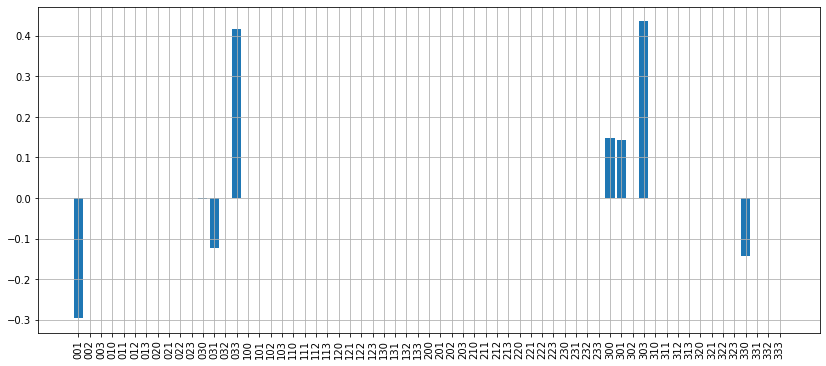

Initial fidelity = 0.5874588572595193
[Fidelity = 0.9233997375987877] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9211278528175101] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9204171826322624] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9196836029065455] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9215694738087099] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9206450231897874] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9224066084507374] No good Omega direction; giving it a push in random direction
Final fidelity = 0.5921469738223738
[Fidelity = 0.9233997375987877] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9200781830634146] No good Omega direction; giving it a push in random direction
[Fidelity = 0.9216126366471328] No good Omega direction; giving it a push in ran

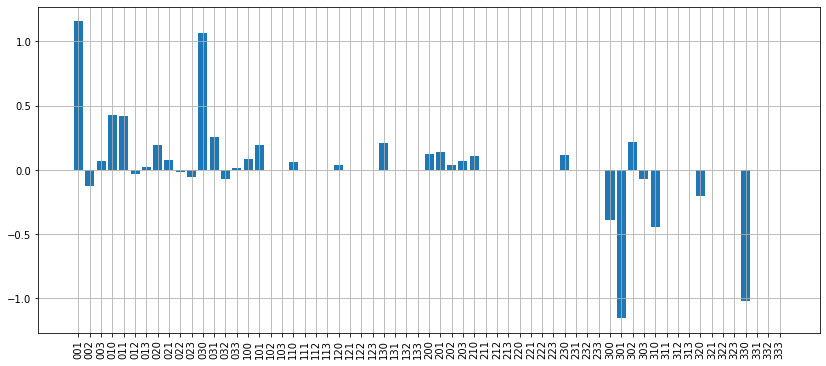

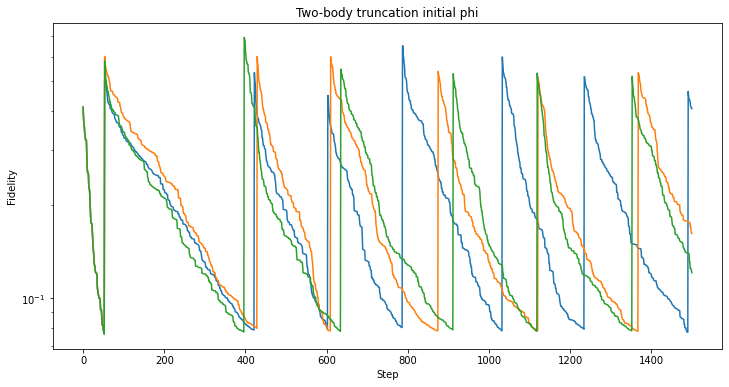

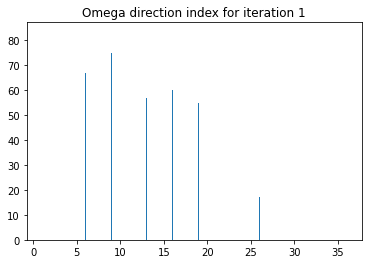

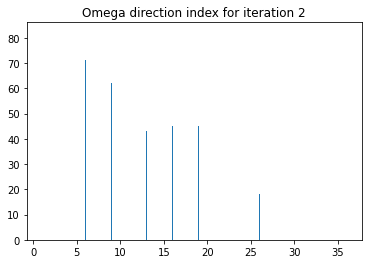

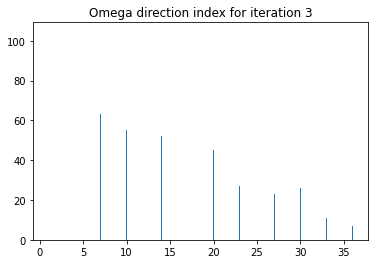

In [390]:
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

theta_solution = parameters_from_hamiltonian(-1.j*spla.logm(Vtoff), basis_full["basis"])

specific_labels = [(3,0,0), (0,3,0), (3,0,1), (0,3,1), (3,3,0), (0,0,1), (0,3,3), (3,0,3)]
ts = list(np.random.rand(8) - 1/2)
theta_solution = specific_basis_terms(basis_full, specific_labels, ts)
plot_parameters(basis_full["labels"], theta_solution)

print(f"Initial fidelity = {phi_fidelity(theta_solution, basis_full['basis'], Vtoff)}")

# np.diag(len(theta_solution))
multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices = anchor_init_fidelities(theta_solution, Vtoff, basis_full, num_steps=1500, step_size=0.01, update_func=geodesic_direction_update_step, precision=0.999)
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)
    
plot_parameters(basis_full["labels"], phis[-1])
plot_multi_fidelities(multi_steps, multi_fidelities, title="Two-body truncation initial phi")
for i, indices in enumerate(multi_indices):
    plot_direction_indices(indices, title=f"Omega direction index for iteration {i+1}")